In [1]:
import pandas as pd
import time
import pickle
import csv
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score

In [2]:
cities = pd.read_csv("citiesWWeather.csv")
with open("weatherDict.pkl", 'rb') as f:
    weatherDict = pickle.load(f)

In [3]:
weatherToColor = {
    0: 0, 1: 0, 2: 1, 3: 1,
    45: 2, 48: 2,
    51: 3, 53: 4, 55: 5, 56: 5, 57: 6, 
    61: 5, 63: 6, 65: 7, 66: 7, 67: 8,
    71: 5, 73: 6, 75: 7, 77: 6,
    80: 6, 81: 7, 82: 8,
    85: 7, 86: 8,
    95: 9, 96: 9, 99: 10,
}

Text(0.5, 0.98, 'Weather Progression in Europe Jan 2024')

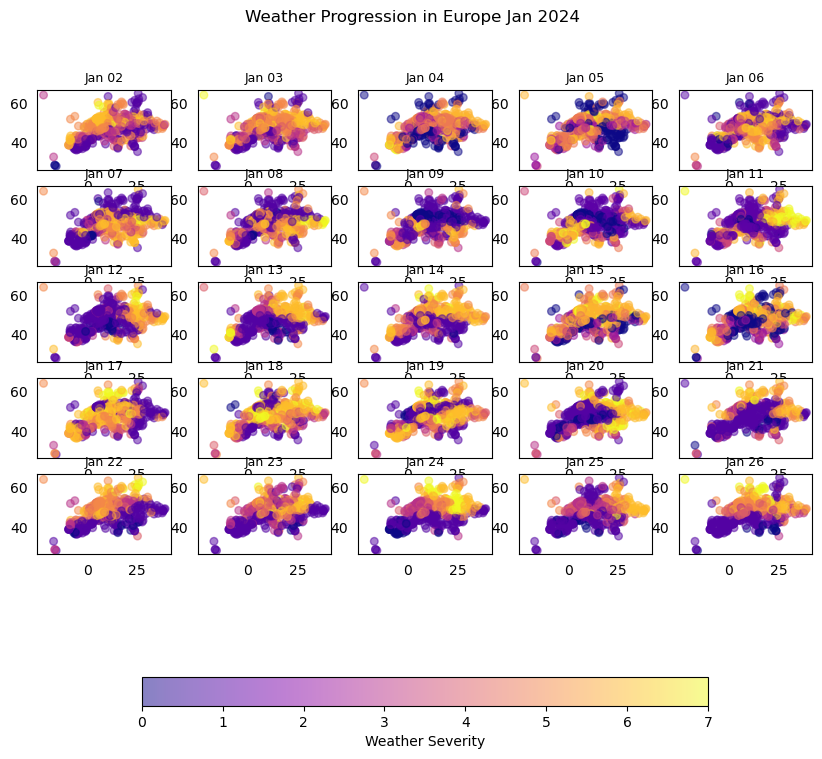

In [4]:
target = "1-2-2024"
start = datetime.strptime(target, "%m-%d-%Y")
# target = "6-1"
# end = datetime.strptime(target, "%m-%d")

fig, axes = plt.subplots(5, 5, figsize=(10, 8))
dates = []
for x in range(5):
    for y in range(5):
        longs = []
        lats = []
        codes = []
        for index, row in cities.iterrows():
            longs.append(row['Long'])
            lats.append(row['Lat'])
            data = weatherDict[(row["City"], row["ABBR"])]
            data['time'] = pd.to_datetime(data['time'])
            codes.append(weatherToColor[data[data['time'] == start]["weather_code"].item()])
            # print(len(weatherCode))
            # break

        scatter = axes[x, y].scatter(longs, lats, c=codes, 
                               cmap='plasma', alpha=0.5, s=30, )
        axes[x, y].tick_params(bottom=False)

        axes[x, y].tick_params(left=False)
        axes[x, y].set_title((start).strftime("%b %d"), fontsize=9)
        start = start+timedelta(days=1)
                               
fig.colorbar(scatter, ax=axes.ravel().tolist(), 
            label='Weather Severity',
            orientation='horizontal',
            pad=0.2,
            fraction=0.046)
fig.suptitle('Weather Progression in Europe Jan 2024')
plt.show()

This map shows the progression of one of the largest storms in Europe in recent years. I wanted to try using subplots to visualize this.

In [9]:
numerical_features = [
    'QOL',
    'Sal',
    'Total COL',
    'Rent',
    'Snow Days/Y',
    'Snow Fall/Y',
    'Total Temps Ave',
    'Summer Temps Ave',
    'Spring Temps Ave',
    'Winter Temps Ave',
    'Fall Temps Ave',
    'Sunny Days/Y',
    'Hours Rained/Y',
    'Winter Daylight',
]

In [10]:
X = cities[numerical_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(X_scaled)

,n_clusters,6
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [12]:
cities['Cluster'] = kmeans.fit_predict(X_scaled)

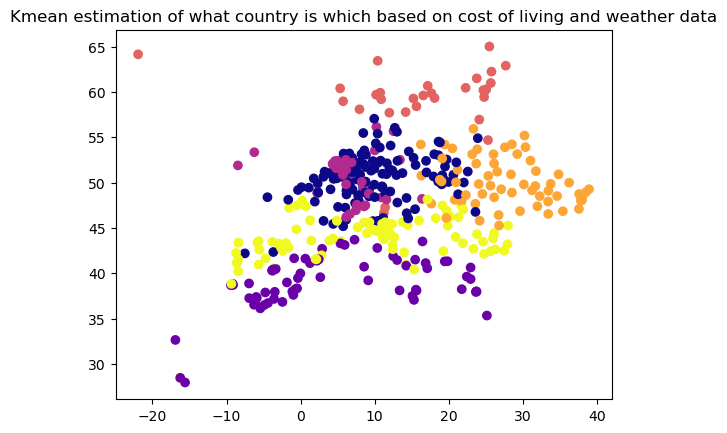

In [13]:
scatter = plt.scatter(cities['Long'], cities['Lat'], c=cities['Cluster'], cmap='plasma')
plt.title("Kmean estimation of what country is which based on cost of living and weather data")
plt.show()

For this I wanted to see how telling my data was so I used kmeans to try and predict country/region just off of the information given. I thought it was pretty interesting how accurately it did to an extent.

In [70]:
temp = pd.DataFrame(data=X_scaled)
citiesScaled = cities.copy()
count = 0
for col in numerical_features:
    citiesScaled[col] = temp[count]
    count += 1
# citiesScaled

In [118]:
citiesScaled["Ben Score"] = 0

# addition count: 2+5
for index, row in citiesScaled.iterrows():
    score = int(
        row["QOL"] * 30
        -abs((row["Snow Days/Y"]+0.3))*20
        -row["Total COL"] * 10
        -row["Rent"] * 8
        +row["Sunny Days/Y"]*10
        +row["Winter Daylight"]
        -row["Hours Rained/Y"]*4
        -row["Summer Temps Ave"]*10
        # -abs(max(0, row["Summer Temps Ave"]-30)) * 3 #maybe add column for hot days
    )
    citiesScaled.loc[index, "Ben Score"] = score

min_score = citiesScaled["Ben Score"].min()
max_score = citiesScaled["Ben Score"].max()
citiesScaled["Ben Score"] = ((citiesScaled["Ben Score"] - min_score) / 
                              (max_score - min_score) * 100).astype(int)

citiesScaled.iloc[0:len(weatherDict)].sort_values("Ben Score", ascending = False).head(10)

,Country,Province,City,Pop.,ABBR,Rent,Total COL,Sal,QOL,Prov. ABBR,...,Winter Temps Ave,Fall Temps Ave,Highest 3 Year,Lowest 3 Year,Most Days,Sunny Days/Y,Hours Rained/Y,Winter Daylight,Cluster,Ben Score
115,Germany,North Rhine-Westphalia,Essen,"582,600",DE,-0.343044,0.069574,1.007871,1.437475,NW,...,-0.001118,-0.219792,16.5,-3.2,Overcast,-0.525801,1.304087,-0.435961,0,100
122,Germany,Saxony-Anhalt,Halle,"237,000",DE,-0.544942,-0.169714,0.796209,1.139984,ST,...,-0.293568,-0.425367,17.5,-6.2,Overcast,-0.330372,-0.271403,-0.448719,0,97
296,Spain,Andalusia,Huelva,"142,532",ES,-0.302664,-0.399654,-0.608025,-0.049977,NaN,...,1.958411,1.966495,23.0,5.9,Overcast,4.408796,-1.679488,1.479754,1,93
220,Greece,Crete,Heraklion,"145,440",GR,-0.495910,-0.416479,-0.937364,-0.198722,NaN,...,2.188160,2.389601,24.7,8.7,Overcast,5.166085,-1.582379,1.670193,1,93
149,Germany,North Rhine-Westphalia,Neuss,"155,400",DE,0.271305,0.320077,0.283640,1.139984,NW,...,0.010190,-0.215953,16.9,-3.0,Overcast,-0.574659,0.710561,-0.397975,0,92
109,Germany,North Rhine-Westphalia,Dortmund,"586,200",DE,-0.066154,0.286428,0.894142,1.214357,NW,...,-0.046443,-0.276287,16.7,-3.5,Overcast,-0.403658,1.321480,-0.448719,0,91
107,Germany,North Rhine-Westphalia,Cologne,"1,060,600",DE,0.882769,0.914557,0.766987,1.437475,NW,...,0.026003,-0.164724,17.2,-2.0,Overcast,-0.403658,0.788828,-0.347978,2,91
70,France,Auvergne-Rhône-Alpes,Saint-Étienne,"172,718",FR,-0.648776,-0.448259,0.027750,0.693749,ARA,...,-0.104087,-0.161981,16.7,-3.9,Overcast,-0.183800,0.151820,0.503534,0,90
119,Germany,North Rhine-Westphalia,Gelsenkirchen,"260,400",DE,-0.169988,0.050879,0.031699,1.065612,NW,...,0.012212,-0.220670,16.6,-3.8,Overcast,-0.501373,1.170018,-0.448719,0,90
143,Germany,Baden-Württemberg,Mannheim,"305,800",DE,0.626070,0.647228,2.108039,1.288730,BW,...,-0.117234,-0.229775,16.8,-2.8,Overcast,-0.501373,0.359083,-0.096895,2,90


Text(0.5, 1.0, 'Ben Scores by City')

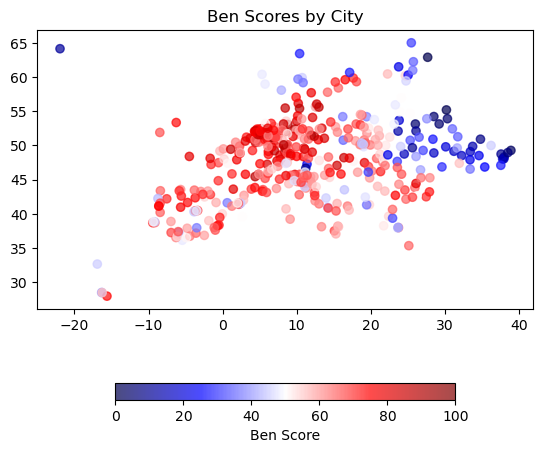

In [116]:
scatter = plt.scatter(citiesScaled["Long"], citiesScaled["Lat"], c=citiesScaled["Ben Score"], cmap='seismic', alpha=0.7)
plt.colorbar(scatter, label='Ben Score',
            orientation='horizontal',
            pad=0.2,
            fraction=0.046)
plt.title("Ben Scores by City")

After I scaled the variables to minimize varience in data, I weighted certain factors based on how important they are to me. This created ben scores, which I plotted each place with their ben scores to find what reg

In [91]:
len(citiesScaled)

439

In [93]:
citiesScaled["QOL"].argmax()

np.int64(400)

In [94]:
# citiesScaled.iloc[400]

Country             Switzerland
Province                 Zürich
City                     Zürich
Pop.                    397,000
ABBR                         CH
Rent                   4.366962
Total COL              4.135589
Sal                    4.625077
QOL                    1.734965
Prov. ABBR                  NaN
Lat                   47.374449
Long                   8.541042
Snow Days/Y            0.576879
Snow Fall/Y             0.46064
Total Temps Ave       -0.435861
Summer Temps Ave      -0.273793
Spring Temps Ave      -0.475237
Winter Temps Ave      -0.410051
Fall Temps Ave        -0.483287
Highest 3 Year             15.5
Lowest 3 Year              -4.7
Most Days              Overcast
Sunny Days/Y          -0.770088
Hours Rained/Y         1.268577
Winter Daylight        0.232336
Cluster                       2
Ben Score                    27
Name: 400, dtype: object